In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


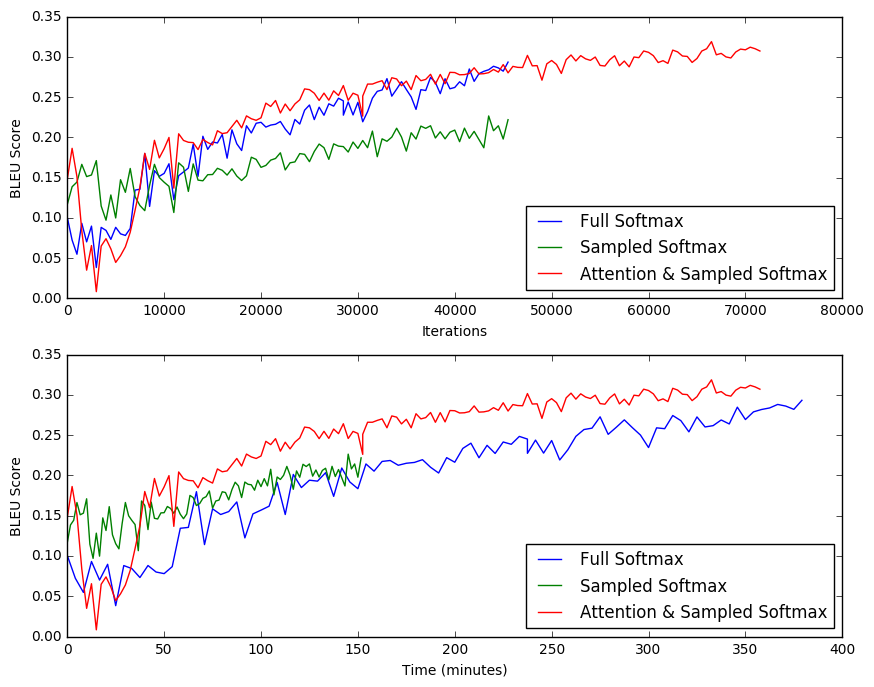

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
def readSSV(fn):
    f = open(fn)
    keys = []; vals = [];
    for line in iter(f):
        attrs = line.split(' ')
        keys.append(int(attrs[0]))
        vals.append(float(attrs[1]))
    f.close()
    return keys, vals

full_step, full_bleus = readSSV('bleus_full.txt')
attn_step, attn_bleus = readSSV('bleus_attns.txt')
sampled_step, sampled_bleus = readSSV('bleus_sampled.txt')

full_time = [float(a*0.5/60.0) for a in full_step]
attn_time = [float(a*0.3/60.0) for a in attn_step]
sampled_time = [float(a*0.2/60.0) for a in sampled_step]

plt.subplot(2, 1, 1)
plt.plot(full_step, full_bleus, label="Full Softmax")
plt.plot(sampled_step, sampled_bleus, label="Sampled Softmax")
plt.plot(attn_step, attn_bleus, label="Attention & Sampled Softmax")
plt.legend(loc='lower right')
plt.xlabel("Iterations")
plt.ylabel("BLEU Score")

plt.subplot(2, 1, 2)
plt.plot(full_time, full_bleus, label="Full Softmax")
plt.plot(sampled_time, sampled_bleus, label="Sampled Softmax")
plt.plot(attn_time, attn_bleus, label="Attention & Sampled Softmax")
plt.legend(loc='lower right')
plt.xlabel("Time (minutes)")
plt.ylabel("BLEU Score")

In [8]:
import tensorflow as tf, re, time, math
from seq2seq_model import *
from wmt_data import *

V_en = 50000;
V_fr = 70000;

en_train, fr_train, en_dev, fr_dev, en_vocab_path, fr_vocab_path = prepare_wmt_data(V_en, V_fr)

vocab_en, rev_vocab_en = initialize_vocabulary(en_vocab_path)
vocab_fr, rev_vocab_fr = initialize_vocabulary(fr_vocab_path)

# embedding is expected to be of shape (V, D)

a = 'man'
b = 'woman'
c = 'king'
def analogy(a,b,c, vocab, rev_vocab, n=10):
    # Compute the word that is closer to a-b+c
    # n is the number of candidates you want to keep
    # Example: man-woman + king \simeq queen
    a_i = vocab[a]; b_i = vocab[b]; c_i = vocab[c]
    a_emb = embedding[a_i, :]; b_emb = embedding[b_i, :]; c_emb = embedding[c_i, :]; 
    vec = a_emb - b_emb + c_emb
    projs = np.dot(embedding, vec) # Dimension V x 1
    good_is = projs.argsort()[-10:][::-1]
    return [rev_vocab[i] for i in good_is]

print analogy('man', 'woman', 'king', vocab_en, rev_vocab_en)

NameError: global name 'embedding' is not defined